In [1]:
%matplotlib inline
import os
import csv

import matplotlib.pyplot as plt
import torch
from torch import optim
from torch.nn import functional as F
import pandas as pd
import numpy as np

from nbeats_pytorch.model import NBeatsNet 

# split data into batches without bootstrap and shuffling (for testing)
def split(arr, size):
    arrays = []
    while len(arr) > size:
        slice_ = arr[:size]
        arrays.append(slice_)
        arr = arr[size:]
    arrays.append(arr)
    return arrays

# split data into batches with bootstrap
def bootstrap_batch(arr, target, size):
    idx = np.random.choice(len(arr), size, replace=True)
    return arr[idx], target[idx]

# data generator
def batcher(x, y, batch_size, infinite=False):
    if infinite: # training
        while True:
            x_, y_ = bootstrap_batch(x, y, batch_size)
            yield x_, y_
    else: # evaluating
        for x_, y_ in zip(split(x, batch_size), split(y, batch_size)):
            yield x_, y_

# save model to file
def save(model, optimiser, grad_step, checkpoint_name):
    torch.save({
        'grad_step': grad_step,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimiser.state_dict(),
    }, checkpoint_name)

# load model from file
def load(model, checkpoint_name, optimiser=None):
    if os.path.exists(checkpoint_name):
        checkpoint = torch.load(checkpoint_name)
        model.load_state_dict(checkpoint['model_state_dict'])
        if optimiser is not None:
            optimiser.load_state_dict(checkpoint['optimizer_state_dict'])
        grad_step = checkpoint['grad_step']
        print(f'Restored checkpoint from {checkpoint_name}.')
        return grad_step
    return 0

# plots forecast of a model into a file
def plot(net, x, target, backcast_length, forecast_length, grad_step):
    net.eval()
    _, f = net(torch.tensor(x, dtype=torch.float))
    
    fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(8, 8))
    plt.subplots_adjust(top=0.88)
    for i in range(3):
        for j in range(3):
            index = 3 * i + j
            ff, xx, yy = f.cpu().numpy()[index], x[index], target[index]
            ax[i, j].plot(range(0, backcast_length), xx, color='b')
            ax[i, j].plot(range(backcast_length, backcast_length + \
                                forecast_length), yy, color='g')
            ax[i, j].plot(range(backcast_length, backcast_length + \
                                forecast_length), ff, color='r')

    
    output = 'n_beats_{}.png'.format(grad_step)
    plt.savefig(output)
    plt.clf()
    print('Saved image to {}.'.format(output))

# function to load m4 data for training n-beats
def get_m4_data_training(backcast_length, forecast_length, Lh, data_type):
    
    data_type = data_type[0].upper() + data_type[1:]

    x_ts = []
    headers = True
    with open('./data/m4/{}-train.csv'.format(data_type), "r") as file:
        reader = csv.reader(file, delimiter=',')
        for line in reader:
            line = line[1:]
            if not headers:
                x_ts.append(line)
            if headers:
                headers = False
    x_ts_train = np.array(x_ts)
    
    x = np.empty((x_ts_train.shape[0], backcast_length))
    y = np.empty((x_ts_train.shape[0], forecast_length))
    
    for i in range(x_ts_train.shape[0]):
        time_series = np.array(x_ts_train[i])
        time_series = [float(s) for s in time_series if s != '']
        time_series_cleaned = np.array(time_series)
        time_series_cleaned_forlearning_x = np.zeros((1, backcast_length))
        time_series_cleaned_forlearning_y = np.zeros((1, forecast_length))

        # split point
        j = max(int(len(time_series_cleaned) * backcast_length / \
                (backcast_length + forecast_length)), len(time_series_cleaned) - 1 - \
                np.random.randint(0, int(Lh * forecast_length)))
        
        nonzero_input = time_series_cleaned[max(0, j - backcast_length): j]
        time_series_cleaned_forlearning_x[0, -len(nonzero_input):] = nonzero_input
        
        nonzero_target = time_series_cleaned[j:j + forecast_length]
        time_series_cleaned_forlearning_y[0, : len(nonzero_target)] = nonzero_target

        x[i] = time_series_cleaned_forlearning_x
        y[i] = time_series_cleaned_forlearning_y

    print(x.shape, y.shape)
    return x, y

# function to load fred data for training n-beats
def get_fred_data_training(backcast_length, forecast_length, Lh, data_type):
    
    x_ts = []
    with open('./data/fred/{}_final.csv'.format(data_type), "r") as file:
        reader = csv.reader(file, delimiter=',')
        for line in reader:
            ts = np.array(line).astype(float)
            x_ts.append(ts)
            
    x_ts_train = np.array(x_ts)
    
    x = np.empty((x_ts_train.shape[0], backcast_length))
    y = np.empty((x_ts_train.shape[0], forecast_length))
    
    for i in range(x_ts_train.shape[0]):
        
        time_series_cleaned = x_ts_train[i]
        time_series_cleaned_forlearning_x = np.zeros((1, backcast_length))
        time_series_cleaned_forlearning_y = np.zeros((1, forecast_length))

        # split point
        j = max(int(len(time_series_cleaned) * backcast_length / \
                (backcast_length + forecast_length)), len(time_series_cleaned) - 1 - \
                np.random.randint(0, int(Lh * forecast_length)))
        
        nonzero_input = time_series_cleaned[max(0, j - backcast_length): j]
        time_series_cleaned_forlearning_x[0, -len(nonzero_input):] = nonzero_input
        
        nonzero_target = time_series_cleaned[j:j + forecast_length]
        time_series_cleaned_forlearning_y[0, : len(nonzero_target)] = nonzero_target

        x[i] = time_series_cleaned_forlearning_x
        y[i] = time_series_cleaned_forlearning_y

    print(x.shape, y.shape)
    return x, y


# function to load fred data for training n-beats with interpolation
def get_fred_data_training_interpolation(backcast_length, forecast_length, Lh, data_type):
   
    def interpolate(left_point, nonzero_data):
        interpolation = np.empty(len(nonzero_data))
        interpolation[0] = (left_point + nonzero_data[0]) * 0.5
        interpolation[1:] = (nonzero_data[:-1] + nonzero_data[1:]) * 0.5
        return np.insert(nonzero_data, np.arange(len(interpolation)), interpolation)
   
   
    x_ts = []
    with open('./data/fred/{}_final.csv'.format(data_type), "r") as file:
        reader = csv.reader(file, delimiter=',')
        for line in reader:
            ts = np.array(line).astype(float)
            x_ts.append(ts)
           
    x_ts_train = np.array(x_ts)
   
    x = np.empty((x_ts_train.shape[0], backcast_length))
    y = np.empty((x_ts_train.shape[0], forecast_length))
   
    backcast_shape_forlearning = (1, backcast_length)
    forcast_shape_forlearning = (1, forecast_length)
    backcast_length //= 2
    forecast_length //= 2
   
    for i in range(x_ts_train.shape[0]):
       
        time_series_cleaned = x_ts_train[i]
        time_series_cleaned_forlearning_x = np.zeros(backcast_shape_forlearning)
        time_series_cleaned_forlearning_y = np.zeros(forcast_shape_forlearning)
 
        # split point
        j = max(int(len(time_series_cleaned) * backcast_length / \
                (backcast_length + forecast_length)), \
                len(time_series_cleaned) - 1 - \
                np.random.randint(0, int(Lh * forecast_length)))
       
        start = max(0, j - backcast_length)
        left_point_train = 0
        if start > 0:
            left_point_train = time_series_cleaned[start - 1]
        nonzero_input = time_series_cleaned[start: j]
        nonzero_input = interpolate(left_point_train, nonzero_input)
        time_series_cleaned_forlearning_x[0, -len(nonzero_input):] = nonzero_input
       
        nonzero_target = time_series_cleaned[j:j + forecast_length]
        nonzero_target = interpolate(time_series_cleaned[j - 1], nonzero_target)
        time_series_cleaned_forlearning_y[0, : len(nonzero_target)] = nonzero_target
 
        x[i] = time_series_cleaned_forlearning_x
        y[i] = time_series_cleaned_forlearning_y
 
    print(x.shape, y.shape)
    return x, y


# loss function
def smape_loss(output, target):
    nonzero_mask = target != 0
    target = target[nonzero_mask]
    output = output[nonzero_mask]
    
    numerator = torch.abs(output - target)
    denominator = torch.abs(output) + torch.abs(target)
    elementwise_smape = torch.div(numerator, denominator)
        
    nan_mask = torch.isnan(elementwise_smape)
    loss = elementwise_smape[~nan_mask].mean() * 200
    
    return loss

# function to train n-beats
def fit_smape(net, optimiser, data_generator, on_save_callback, device, \
               max_grad_steps, checkpoint_name):
    print('--- Training ---')
    losses = []
    
    net.train()
    initial_grad_step = load(net, checkpoint_name, optimiser)
    for grad_step, (x, target) in enumerate(data_generator):
        
        grad_step += initial_grad_step
        optimiser.zero_grad()
        backcast, forecast = net(torch.tensor(x, dtype=torch.float).to(device))
        loss = smape_loss(forecast, torch.tensor(target, dtype=torch.float).to(device))
        loss.backward()
        optimiser.step()
        if grad_step % 100 == 0:
            print(f'grad_step = {str(grad_step).zfill(6)}, loss = {loss.item():.6f}')
        losses.append(loss.item())
        if grad_step % 500 == 0 or (grad_step < 1000 and grad_step % 200 == 0):
            with torch.no_grad():
                save(net, optimiser, grad_step, checkpoint_name)
        if grad_step > max_grad_steps:
            print('Finished.')
            with torch.no_grad():
                if on_save_callback is not None:
                    on_save_callback(x, target, grad_step)
            break
            
    plt.plot(losses)
    plt.show()
    return losses

In [ ]:
# parameter to set ('yearly', 'quarterly', 'monthly', 'weekly', 'daily', 'hourly') for M4
# ('yearly', 'quarterly', 'monthly') for fred         
data_type = 'monthly'
dataset = 'fred'

if data_type == 'yearly':
    forecast_length = 6
    Lh = 1.5
    max_grad_steps = 15000
elif data_type == 'quarterly':
    forecast_length = 8
    Lh = 1.5
    max_grad_steps = 15000
elif data_type == 'monthly':
    forecast_length = 18
    Lh = 1.5
    max_grad_steps = 15000
elif data_type == 'weekly':
    forecast_length = 13
    Lh = 10
    max_grad_steps = 5000
elif data_type == 'daily':
    forecast_length = 14
    Lh = 10
    max_grad_steps = 5000
else: # data_type == 'hourly'
    forecast_length = 48
    Lh = 10
    max_grad_steps = 5000

batch_size = 1024
    
folder = './{}_checkpoints_{}/'.format(dataset, data_type)

for i in range(2, 8):
    print('-------------------------------------')
    print(i)
    
    device = 'cuda:1' if torch.cuda.is_available() else torch.device('cpu')
    backcast_length = i * forecast_length

    if dataset == 'm4':
        x, y = get_m4_data_training(backcast_length, forecast_length, Lh, data_type)
        
        # scaling data for m4 (does not contain negative elements)
        max_consts = x.max(axis=1)
        x_scaled = x.copy()
        for j in range(x.shape[1]):
            x_scaled[:, j] /= max_consts

        y_scaled = y.copy()
        for j in range(y.shape[1]):
            y_scaled[:, j] /= max_consts
        
    else: # dataset == 'fred'
        x, y = get_fred_data_training_interpolation(backcast_length, forecast_length, Lh, data_type)
        
        max_consts = np.empty(x.shape[0])
        min_consts = np.empty(x.shape[0])
        nonzero_mask = np.ones(x.shape[0], dtype=bool)
        x_scaled = x.copy()
        for j in range(x_scaled.shape[0]):
            ts_nonzero = np.trim_zeros(x_scaled[j], 'f')
            # all-zeros array - drop from training
            if len(ts_nonzero) == 0:
                nonzero_mask[j] = False
                continue
            max_consts[j] = ts_nonzero.max()
            min_consts[j] = ts_nonzero.min()
            # drop ts from learning if it is constant
            if max_consts[j] == min_consts[j]:
                nonzero_mask[j] = False
                continue
            x_scaled[j, -len(ts_nonzero):] = (ts_nonzero - min_consts[j]) / \
                                                 (max_consts[j] - min_consts[j])
    
        x_scaled = x_scaled[nonzero_mask]
        max_consts = max_consts[nonzero_mask]
        min_consts = min_consts[nonzero_mask]
        y_scaled = y.copy()[nonzero_mask]
        for j in range(y_scaled.shape[0]):
            ts_y_nonzero = np.trim_zeros(y_scaled[j], 'b')
            y_scaled[j, :len(ts_y_nonzero)] = (ts_y_nonzero - min_consts[j]) / \
                                                 (max_consts[j] - min_consts[j])
    
    data_gen = batcher(x_scaled, y_scaled, batch_size=batch_size, infinite=True)
    
    checkpoint_name = '{}{}_interpolation_share_{}H_G_2_smape.th'.\
                            format(folder, data_type[:-2], i)
    
    print('--- Model ---')
    n_stacks = 30
    net = NBeatsNet(device=device,
                    stack_types=[NBeatsNet.GENERIC_BLOCK] * n_stacks,
                    forecast_length=forecast_length,
                    thetas_dims=[4] * n_stacks,
                    nb_blocks_per_stack=1,
                    backcast_length=backcast_length,
                    hidden_layer_units=512,
                    share_weights_in_stack=True
                    )

    optimiser = optim.Adam(net.parameters())

    def plot_model(x, target, grad_step):
        plot(net, x, target, backcast_length, forecast_length, grad_step)

    losses = fit_smape(net, optimiser, data_gen, plot_model, device, \
                              max_grad_steps, checkpoint_name)

-------------------------------------
2
(39665, 36) (39665, 18)
--- Model ---
| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=36, forecast_length=18, share_thetas=False) at @22687697401224
| --  Stack Generic (#1) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=36, forecast_length=18, share_thetas=False) at @22687697401896
| --  Stack Generic (#2) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=36, forecast_length=18, share_thetas=False) at @22687697401840
| --  Stack Generic (#3) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=36, forecast_length=18, share_thetas=False) at @22687697402568
| --  Stack Generic (#4) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=36, forecast_length=18, share_thetas=False) at @22687697403240
| 

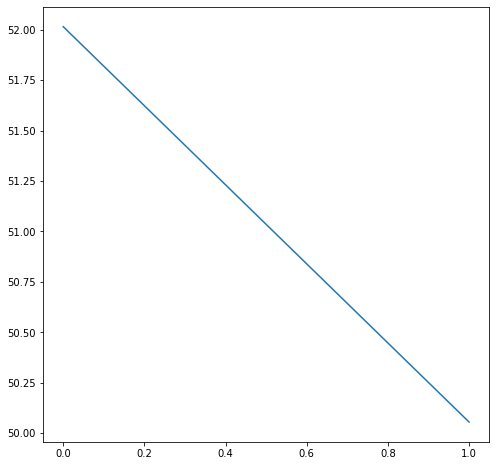

-------------------------------------
3
(39665, 54) (39665, 18)
--- Model ---
| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=54, forecast_length=18, share_thetas=False) at @22684838121824
| --  Stack Generic (#1) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=54, forecast_length=18, share_thetas=False) at @22684838122384
| --  Stack Generic (#2) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=54, forecast_length=18, share_thetas=False) at @22684838123560
| --  Stack Generic (#3) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=54, forecast_length=18, share_thetas=False) at @22684838123504
| --  Stack Generic (#4) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=54, forecast_length=18, share_thetas=False) at @22687294342144
| 

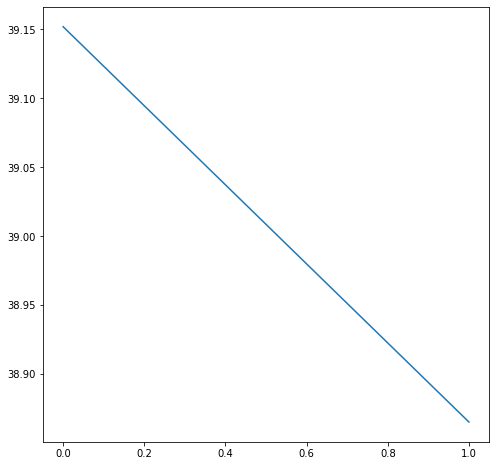

-------------------------------------
4
(39665, 72) (39665, 18)
--- Model ---
| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=72, forecast_length=18, share_thetas=False) at @22687294405208
| --  Stack Generic (#1) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=72, forecast_length=18, share_thetas=False) at @22687297583424
| --  Stack Generic (#2) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=72, forecast_length=18, share_thetas=False) at @22687297581856
| --  Stack Generic (#3) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=72, forecast_length=18, share_thetas=False) at @22687297584320
| --  Stack Generic (#4) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=72, forecast_length=18, share_thetas=False) at @22687297581744
| 

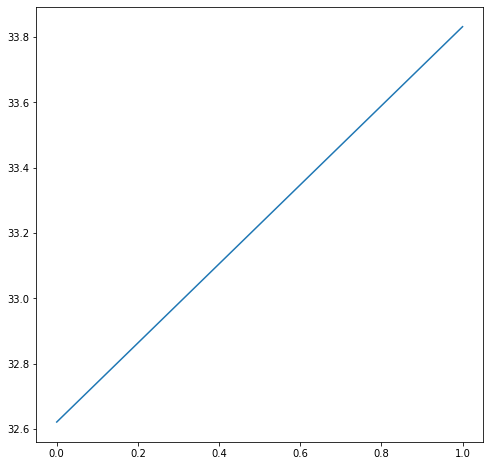

-------------------------------------
5
(39665, 90) (39665, 18)
--- Model ---
| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=90, forecast_length=18, share_thetas=False) at @22687313771936
| --  Stack Generic (#1) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=90, forecast_length=18, share_thetas=False) at @22687313770368
| --  Stack Generic (#2) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=90, forecast_length=18, share_thetas=False) at @22687313770704
| --  Stack Generic (#3) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=90, forecast_length=18, share_thetas=False) at @22687313769080
| --  Stack Generic (#4) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=90, forecast_length=18, share_thetas=False) at @22687313771320
| 

grad_step = 013800, loss = 18.963724
grad_step = 013900, loss = 17.949566
grad_step = 014000, loss = 18.308825
grad_step = 014100, loss = 18.624405
grad_step = 014200, loss = 16.305687
grad_step = 014300, loss = 18.744314
grad_step = 014400, loss = 18.307560
grad_step = 014500, loss = 18.151554
grad_step = 014600, loss = 17.205147
grad_step = 014700, loss = 17.612808
grad_step = 014800, loss = 17.436319
grad_step = 014900, loss = 15.360800
grad_step = 015000, loss = 18.523756
Finished.
Saved image to n_beats_15001.png.


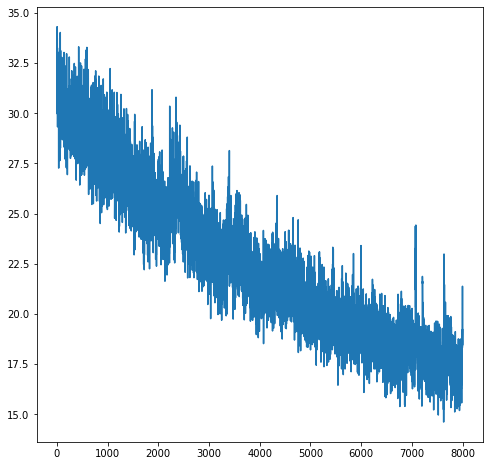

-------------------------------------
6
(39665, 108) (39665, 18)
--- Model ---
| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=108, forecast_length=18, share_thetas=False) at @22687317124936
| --  Stack Generic (#1) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=108, forecast_length=18, share_thetas=False) at @22687313961872
| --  Stack Generic (#2) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=108, forecast_length=18, share_thetas=False) at @22687316338336
| --  Stack Generic (#3) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=108, forecast_length=18, share_thetas=False) at @22687316339848
| --  Stack Generic (#4) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=108, forecast_length=18, share_thetas=False) at @22687315335

grad_step = 007000, loss = 23.559383
grad_step = 007100, loss = 24.966949
grad_step = 007200, loss = 25.778925
grad_step = 007300, loss = 23.951872
grad_step = 007400, loss = 21.724394
grad_step = 007500, loss = 20.800205
grad_step = 007600, loss = 22.128239
grad_step = 007700, loss = 21.246529
grad_step = 007800, loss = 22.812397
grad_step = 007900, loss = 20.348249
grad_step = 008000, loss = 22.161354
grad_step = 008100, loss = 21.974871
grad_step = 008200, loss = 21.726549
grad_step = 008300, loss = 21.493210
grad_step = 008400, loss = 21.694019
grad_step = 008500, loss = 20.812181
grad_step = 008600, loss = 22.131662
grad_step = 008700, loss = 21.018072
grad_step = 008800, loss = 21.817991
grad_step = 008900, loss = 21.944607
grad_step = 009000, loss = 19.751934
grad_step = 009100, loss = 19.850647
grad_step = 009200, loss = 19.308462
grad_step = 009300, loss = 25.911009
grad_step = 009400, loss = 23.886744
grad_step = 009500, loss = 18.701748
grad_step = 009600, loss = 19.739611
g

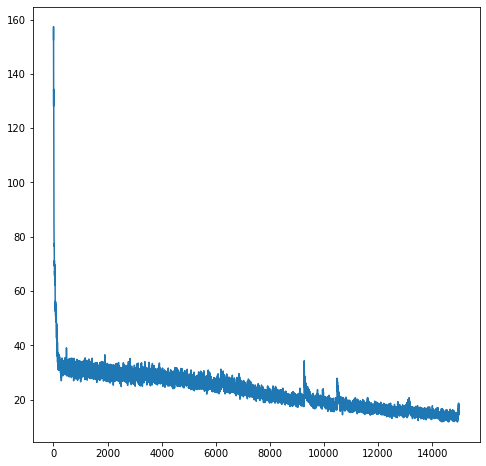

-------------------------------------
7
(39665, 126) (39665, 18)
--- Model ---
| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=126, forecast_length=18, share_thetas=False) at @22687294174600
| --  Stack Generic (#1) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=126, forecast_length=18, share_thetas=False) at @22687316272968
| --  Stack Generic (#2) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=126, forecast_length=18, share_thetas=False) at @22687316272856
| --  Stack Generic (#3) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=126, forecast_length=18, share_thetas=False) at @22687316273304
| --  Stack Generic (#4) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=126, forecast_length=18, share_thetas=False) at @22687316275

grad_step = 007000, loss = 25.689606
grad_step = 007100, loss = 25.607290
grad_step = 007200, loss = 25.296164
grad_step = 007300, loss = 24.225962
grad_step = 007400, loss = 25.350958
grad_step = 007500, loss = 27.012783
grad_step = 007600, loss = 24.712831
grad_step = 007700, loss = 25.446611
grad_step = 007800, loss = 24.995241
grad_step = 007900, loss = 24.915524
grad_step = 008000, loss = 22.931890
grad_step = 008100, loss = 24.625622
grad_step = 008200, loss = 22.785030
grad_step = 008300, loss = 24.361824
grad_step = 008400, loss = 24.836544
grad_step = 008500, loss = 24.391748
grad_step = 008600, loss = 23.703215
grad_step = 008700, loss = 23.161793
grad_step = 008800, loss = 24.220367
grad_step = 008900, loss = 24.208818
grad_step = 009000, loss = 22.643478
grad_step = 009100, loss = 22.738214
grad_step = 009200, loss = 21.863457
grad_step = 009300, loss = 23.249044
grad_step = 009400, loss = 22.553978
grad_step = 009500, loss = 21.358625
grad_step = 009600, loss = 21.647129
g

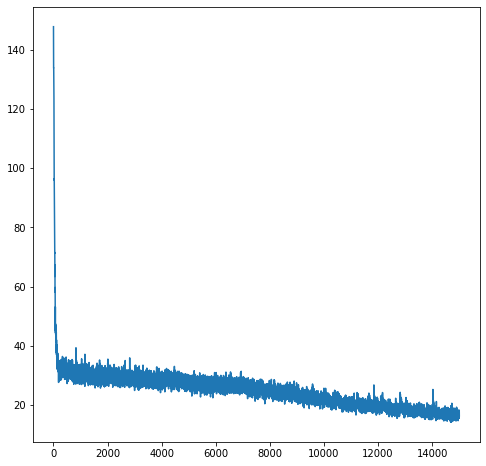

In [2]:
# parameter to set ('yearly', 'quarterly', 'monthly', 'weekly', 'daily', 'hourly') for M4
# ('yearly', 'quarterly', 'monthly') for fred         
data_type = 'monthly'
dataset = 'fred'

if data_type == 'yearly':
    forecast_length = 6
    Lh = 1.5
    max_grad_steps = 15000
elif data_type == 'quarterly':
    forecast_length = 8
    Lh = 1.5
    max_grad_steps = 15000
elif data_type == 'monthly':
    forecast_length = 18
    Lh = 1.5
    max_grad_steps = 15000
elif data_type == 'weekly':
    forecast_length = 13
    Lh = 10
    max_grad_steps = 5000
elif data_type == 'daily':
    forecast_length = 14
    Lh = 10
    max_grad_steps = 5000
else: # data_type == 'hourly'
    forecast_length = 48
    Lh = 10
    max_grad_steps = 5000

batch_size = 1024
    
folder = './{}_checkpoints_{}/'.format(dataset, data_type)

for i in range(2, 8):
    print('-------------------------------------')
    print(i)
    
    device = 'cuda:1' if torch.cuda.is_available() else torch.device('cpu')
    backcast_length = i * forecast_length

    if dataset == 'm4':
        x, y = get_m4_data_training(backcast_length, forecast_length, Lh, data_type)
        
        # scaling data for m4 (does not contain negative elements)
        max_consts = x.max(axis=1)
        x_scaled = x.copy()
        for j in range(x.shape[1]):
            x_scaled[:, j] /= max_consts

        y_scaled = y.copy()
        for j in range(y.shape[1]):
            y_scaled[:, j] /= max_consts
        
    else: # dataset == 'fred'
        x, y = get_fred_data_training_interpolation(backcast_length, forecast_length, Lh, data_type)
        
        max_consts = np.empty(x.shape[0])
        min_consts = np.empty(x.shape[0])
        nonzero_mask = np.ones(x.shape[0], dtype=bool)
        x_scaled = x.copy()
        for j in range(x_scaled.shape[0]):
            ts_nonzero = np.trim_zeros(x_scaled[j], 'f')
            # all-zeros array - drop from training
            if len(ts_nonzero) == 0:
                nonzero_mask[j] = False
                continue
            max_consts[j] = ts_nonzero.max()
            min_consts[j] = ts_nonzero.min()
            # drop ts from learning if it is constant
            if max_consts[j] == min_consts[j]:
                nonzero_mask[j] = False
                continue
            x_scaled[j, -len(ts_nonzero):] = (ts_nonzero - min_consts[j]) / \
                                                 (max_consts[j] - min_consts[j])
    
        x_scaled = x_scaled[nonzero_mask]
        max_consts = max_consts[nonzero_mask]
        min_consts = min_consts[nonzero_mask]
        y_scaled = y.copy()[nonzero_mask]
        for j in range(y_scaled.shape[0]):
            ts_y_nonzero = np.trim_zeros(y_scaled[j], 'b')
            y_scaled[j, :len(ts_y_nonzero)] = (ts_y_nonzero - min_consts[j]) / \
                                                 (max_consts[j] - min_consts[j])
    
    data_gen = batcher(x_scaled, y_scaled, batch_size=batch_size, infinite=True)
    
    checkpoint_name = '{}{}_share_{}H_G_1_smape_interpolation.th'.\
                            format(folder, data_type[:-2], i)
    
    print('--- Model ---')
    n_stacks = 30
    net = NBeatsNet(device=device,
                    stack_types=[NBeatsNet.GENERIC_BLOCK] * n_stacks,
                    forecast_length=forecast_length,
                    thetas_dims=[4] * n_stacks,
                    nb_blocks_per_stack=1,
                    backcast_length=backcast_length,
                    hidden_layer_units=512,
                    share_weights_in_stack=True
                    )

    optimiser = optim.Adam(net.parameters())

    def plot_model(x, target, grad_step):
        plot(net, x, target, backcast_length, forecast_length, grad_step)

    losses = fit_smape(net, optimiser, data_gen, plot_model, device, \
                              max_grad_steps, checkpoint_name)

-------------------------------------
2
(39665, 36) (39665, 18)
--- Model ---
| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=36, forecast_length=18, share_thetas=False) at @23149976737552
| --  Stack Generic (#1) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=36, forecast_length=18, share_thetas=False) at @23149976876984
| --  Stack Generic (#2) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=36, forecast_length=18, share_thetas=False) at @23149976877040
| --  Stack Generic (#3) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=36, forecast_length=18, share_thetas=False) at @23149976878608
| --  Stack Generic (#4) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=36, forecast_length=18, share_thetas=False) at @23149976877264
| 

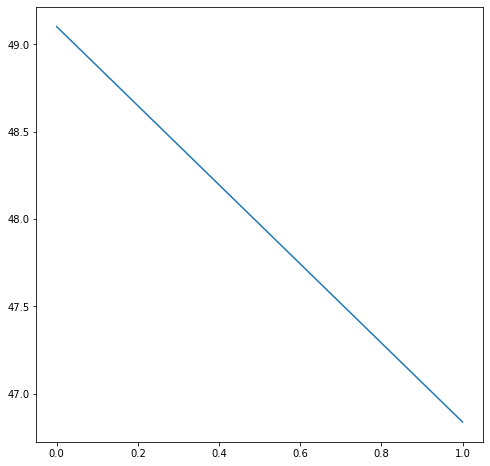

-------------------------------------
3
(39665, 54) (39665, 18)
--- Model ---
| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=54, forecast_length=18, share_thetas=False) at @23149942128368
| --  Stack Generic (#1) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=54, forecast_length=18, share_thetas=False) at @23149540433872
| --  Stack Generic (#2) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=54, forecast_length=18, share_thetas=False) at @23149540432248
| --  Stack Generic (#3) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=54, forecast_length=18, share_thetas=False) at @23149540431744
| --  Stack Generic (#4) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=54, forecast_length=18, share_thetas=False) at @23149540430064
| 

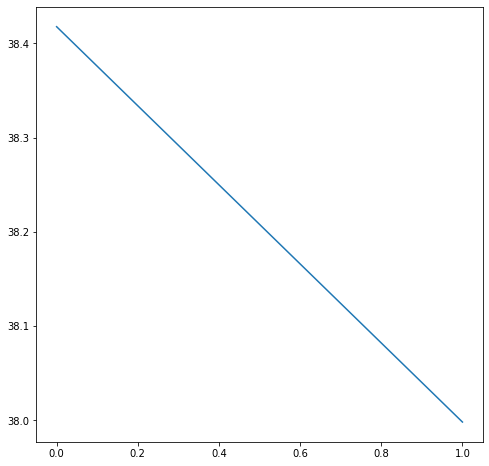

-------------------------------------
4
(39665, 72) (39665, 18)
--- Model ---
| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=72, forecast_length=18, share_thetas=False) at @23149962001824
| --  Stack Generic (#1) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=72, forecast_length=18, share_thetas=False) at @23149961970632
| --  Stack Generic (#2) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=72, forecast_length=18, share_thetas=False) at @23149943826136
| --  Stack Generic (#3) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=72, forecast_length=18, share_thetas=False) at @23149943827144
| --  Stack Generic (#4) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=72, forecast_length=18, share_thetas=False) at @23149943826360
| 

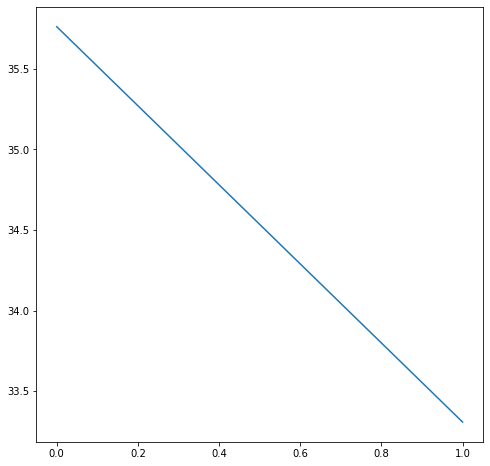

-------------------------------------
5
(39665, 90) (39665, 18)
--- Model ---
| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=90, forecast_length=18, share_thetas=False) at @23149959582048
| --  Stack Generic (#1) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=90, forecast_length=18, share_thetas=False) at @23149959315584
| --  Stack Generic (#2) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=90, forecast_length=18, share_thetas=False) at @23149959317880
| --  Stack Generic (#3) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=90, forecast_length=18, share_thetas=False) at @23149959317600
| --  Stack Generic (#4) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=90, forecast_length=18, share_thetas=False) at @23149959319224
| 

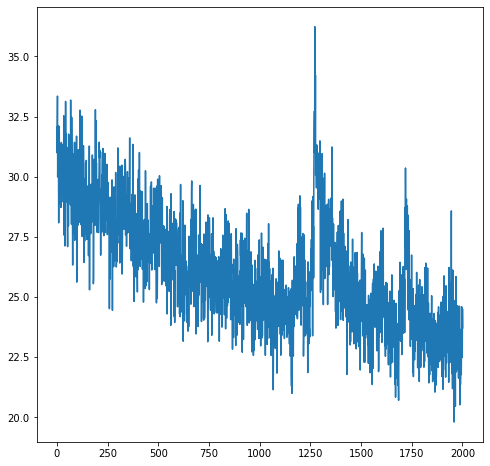

-------------------------------------
6
(39665, 108) (39665, 18)
--- Model ---
| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=108, forecast_length=18, share_thetas=False) at @23149961841296
| --  Stack Generic (#1) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=108, forecast_length=18, share_thetas=False) at @23149961839840
| --  Stack Generic (#2) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=108, forecast_length=18, share_thetas=False) at @23149961841240
| --  Stack Generic (#3) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=108, forecast_length=18, share_thetas=False) at @23149961839392
| --  Stack Generic (#4) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=108, forecast_length=18, share_thetas=False) at @23149961841

grad_step = 007000, loss = 21.350681
grad_step = 007100, loss = 24.817940
grad_step = 007200, loss = 23.159513
grad_step = 007300, loss = 24.640598
grad_step = 007400, loss = 22.213213
grad_step = 007500, loss = 21.763268
grad_step = 007600, loss = 20.885271
grad_step = 007700, loss = 21.619909
grad_step = 007800, loss = 21.991676
grad_step = 007900, loss = 21.133274
grad_step = 008000, loss = 20.208961
grad_step = 008100, loss = 28.336378
grad_step = 008200, loss = 21.153040
grad_step = 008300, loss = 21.310066
grad_step = 008400, loss = 22.323257
grad_step = 008500, loss = 18.867176
grad_step = 008600, loss = 25.497505
grad_step = 008700, loss = 21.246119
grad_step = 008800, loss = 21.423990
grad_step = 008900, loss = 20.266253
grad_step = 009000, loss = 21.017776
grad_step = 009100, loss = 19.889881
grad_step = 009200, loss = 17.622992
grad_step = 009300, loss = 21.496460
grad_step = 009400, loss = 18.754642
grad_step = 009500, loss = 17.810518
grad_step = 009600, loss = 17.694960
g

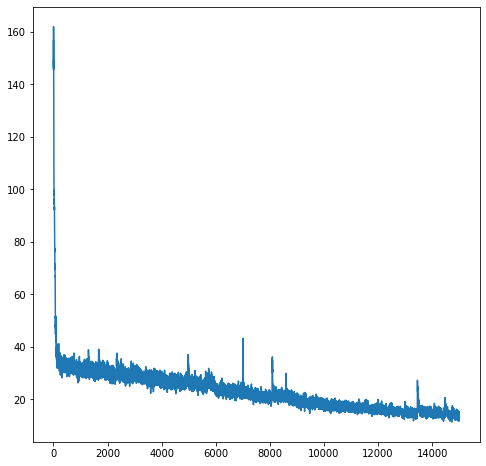

-------------------------------------
7
(39665, 126) (39665, 18)
--- Model ---
| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=126, forecast_length=18, share_thetas=False) at @23149960684152
| --  Stack Generic (#1) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=126, forecast_length=18, share_thetas=False) at @23149958671440
| --  Stack Generic (#2) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=126, forecast_length=18, share_thetas=False) at @23149961044824
| --  Stack Generic (#3) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=126, forecast_length=18, share_thetas=False) at @23149961046504
| --  Stack Generic (#4) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=126, forecast_length=18, share_thetas=False) at @23149961047

grad_step = 007000, loss = 23.087723
grad_step = 007100, loss = 22.356998
grad_step = 007200, loss = 21.778732
grad_step = 007300, loss = 22.002354
grad_step = 007400, loss = 21.799873
grad_step = 007500, loss = 22.628120
grad_step = 007600, loss = 24.259224
grad_step = 007700, loss = 20.697720
grad_step = 007800, loss = 22.188749
grad_step = 007900, loss = 22.234140
grad_step = 008000, loss = 21.925438
grad_step = 008100, loss = 22.112926
grad_step = 008200, loss = 19.577866
grad_step = 008300, loss = 20.739828
grad_step = 008400, loss = 20.099592
grad_step = 008500, loss = 22.267567
grad_step = 008600, loss = 21.380775
grad_step = 008700, loss = 19.568645
grad_step = 008800, loss = 20.778347
grad_step = 008900, loss = 19.492445
grad_step = 009000, loss = 21.048412
grad_step = 009100, loss = 22.852962
grad_step = 009200, loss = 18.461895
grad_step = 009300, loss = 19.879337
grad_step = 009400, loss = 21.515427
grad_step = 009500, loss = 20.357103
grad_step = 009600, loss = 22.629269
g

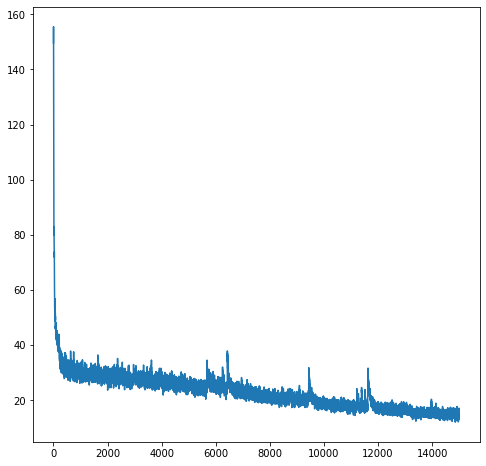

In [2]:
# parameter to set ('yearly', 'quarterly', 'monthly', 'weekly', 'daily', 'hourly') for M4
# ('yearly', 'quarterly', 'monthly') for fred         
data_type = 'monthly'
dataset = 'fred'

if data_type == 'yearly':
    forecast_length = 6
    Lh = 1.5
    max_grad_steps = 15000
elif data_type == 'quarterly':
    forecast_length = 8
    Lh = 1.5
    max_grad_steps = 15000
elif data_type == 'monthly':
    forecast_length = 18
    Lh = 1.5
    max_grad_steps = 15000
elif data_type == 'weekly':
    forecast_length = 13
    Lh = 10
    max_grad_steps = 5000
elif data_type == 'daily':
    forecast_length = 14
    Lh = 10
    max_grad_steps = 5000
else: # data_type == 'hourly'
    forecast_length = 48
    Lh = 10
    max_grad_steps = 5000

batch_size = 1024
    
folder = './{}_checkpoints_{}/'.format(dataset, data_type)

for i in range(2, 8):
    print('-------------------------------------')
    print(i)
    
    device = 'cuda:1' if torch.cuda.is_available() else torch.device('cpu')
    backcast_length = i * forecast_length

    if dataset == 'm4':
        x, y = get_m4_data_training(backcast_length, forecast_length, Lh, data_type)
        
        # scaling data for m4 (does not contain negative elements)
        max_consts = x.max(axis=1)
        x_scaled = x.copy()
        for j in range(x.shape[1]):
            x_scaled[:, j] /= max_consts

        y_scaled = y.copy()
        for j in range(y.shape[1]):
            y_scaled[:, j] /= max_consts
        
    else: # dataset == 'fred'
        x, y = get_fred_data_training_interpolation(backcast_length, forecast_length, Lh, data_type)
        
        max_consts = np.empty(x.shape[0])
        min_consts = np.empty(x.shape[0])
        nonzero_mask = np.ones(x.shape[0], dtype=bool)
        x_scaled = x.copy()
        for j in range(x_scaled.shape[0]):
            ts_nonzero = np.trim_zeros(x_scaled[j], 'f')
            # all-zeros array - drop from training
            if len(ts_nonzero) == 0:
                nonzero_mask[j] = False
                continue
            max_consts[j] = ts_nonzero.max()
            min_consts[j] = ts_nonzero.min()
            # drop ts from learning if it is constant
            if max_consts[j] == min_consts[j]:
                nonzero_mask[j] = False
                continue
            x_scaled[j, -len(ts_nonzero):] = (ts_nonzero - min_consts[j]) / \
                                                 (max_consts[j] - min_consts[j])
    
        x_scaled = x_scaled[nonzero_mask]
        max_consts = max_consts[nonzero_mask]
        min_consts = min_consts[nonzero_mask]
        y_scaled = y.copy()[nonzero_mask]
        for j in range(y_scaled.shape[0]):
            ts_y_nonzero = np.trim_zeros(y_scaled[j], 'b')
            y_scaled[j, :len(ts_y_nonzero)] = (ts_y_nonzero - min_consts[j]) / \
                                                 (max_consts[j] - min_consts[j])
    
    data_gen = batcher(x_scaled, y_scaled, batch_size=batch_size, infinite=True)
    
    checkpoint_name = '{}{}_share_{}H_G_3_smape_interpolation.th'.\
                            format(folder, data_type[:-2], i)
    
    print('--- Model ---')
    n_stacks = 30
    net = NBeatsNet(device=device,
                    stack_types=[NBeatsNet.GENERIC_BLOCK] * n_stacks,
                    forecast_length=forecast_length,
                    thetas_dims=[4] * n_stacks,
                    nb_blocks_per_stack=1,
                    backcast_length=backcast_length,
                    hidden_layer_units=512,
                    share_weights_in_stack=True
                    )

    optimiser = optim.Adam(net.parameters())

    def plot_model(x, target, grad_step):
        plot(net, x, target, backcast_length, forecast_length, grad_step)

    losses = fit_smape(net, optimiser, data_gen, plot_model, device, \
                              max_grad_steps, checkpoint_name)

-------------------------------------
2
(94093, 12) (94093, 6)
--- Model ---
| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=12, forecast_length=6, share_thetas=False) at @23316697657016
| --  Stack Generic (#1) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=12, forecast_length=6, share_thetas=False) at @23316695031144
| --  Stack Generic (#2) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=12, forecast_length=6, share_thetas=False) at @23316695029240
| --  Stack Generic (#3) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=12, forecast_length=6, share_thetas=False) at @23316695031368
| --  Stack Generic (#4) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=12, forecast_length=6, share_thetas=False) at @23316695030192
| --  St

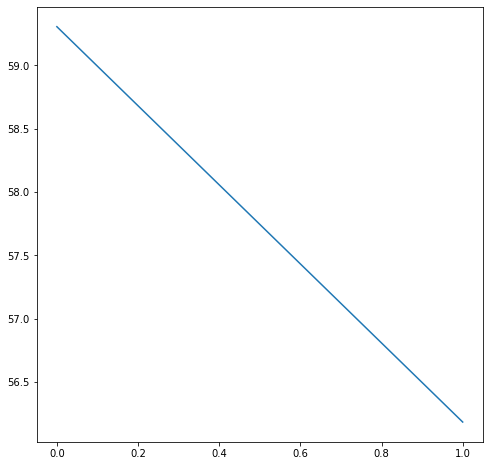

-------------------------------------
3
(94093, 18) (94093, 6)
--- Model ---
| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=18, forecast_length=6, share_thetas=False) at @23316647201312
| --  Stack Generic (#1) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=18, forecast_length=6, share_thetas=False) at @23316102349768
| --  Stack Generic (#2) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=18, forecast_length=6, share_thetas=False) at @23316102194120
| --  Stack Generic (#3) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=18, forecast_length=6, share_thetas=False) at @23316102196640
| --  Stack Generic (#4) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=18, forecast_length=6, share_thetas=False) at @23316102194680
| --  St

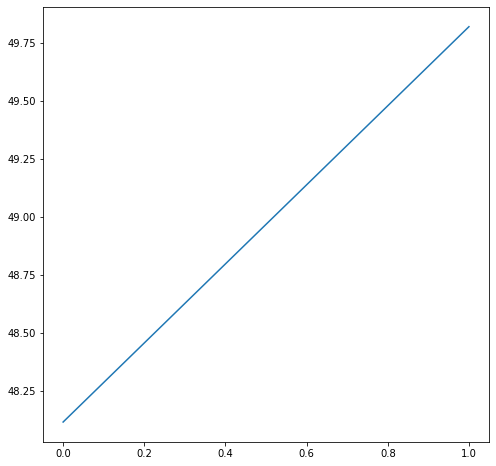

-------------------------------------
4
(94093, 24) (94093, 6)
--- Model ---
| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=24, forecast_length=6, share_thetas=False) at @23316653746160
| --  Stack Generic (#1) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=24, forecast_length=6, share_thetas=False) at @23316652098224
| --  Stack Generic (#2) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=24, forecast_length=6, share_thetas=False) at @23316646881600
| --  Stack Generic (#3) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=24, forecast_length=6, share_thetas=False) at @23316646773872
| --  Stack Generic (#4) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=24, forecast_length=6, share_thetas=False) at @23316646774264
| --  St

grad_step = 015000, loss = 40.685108
Finished.
Saved image to n_beats_15001.png.


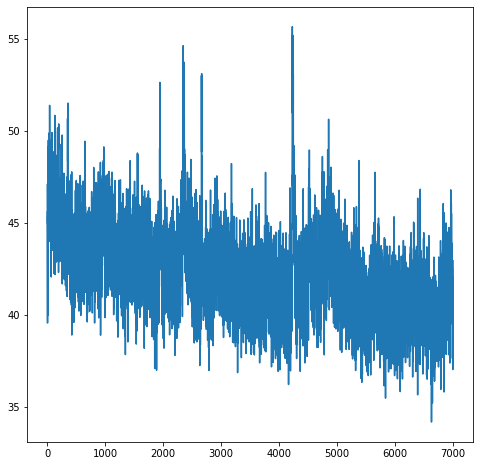

-------------------------------------
5
(94093, 30) (94093, 6)
--- Model ---
| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=30, forecast_length=6, share_thetas=False) at @23316102218864
| --  Stack Generic (#1) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=30, forecast_length=6, share_thetas=False) at @23316651019736
| --  Stack Generic (#2) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=30, forecast_length=6, share_thetas=False) at @23316645918312
| --  Stack Generic (#3) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=30, forecast_length=6, share_thetas=False) at @23316644675032
| --  Stack Generic (#4) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=30, forecast_length=6, share_thetas=False) at @23316645629680
| --  St

grad_step = 007200, loss = 43.602139
grad_step = 007300, loss = 41.326088
grad_step = 007400, loss = 44.982037
grad_step = 007500, loss = 42.734997
grad_step = 007600, loss = 43.190010
grad_step = 007700, loss = 43.616119
grad_step = 007800, loss = 43.169041
grad_step = 007900, loss = 41.500813
grad_step = 008000, loss = 39.770855
grad_step = 008100, loss = 46.977600
grad_step = 008200, loss = 44.194702
grad_step = 008300, loss = 42.664482
grad_step = 008400, loss = 42.525532
grad_step = 008500, loss = 41.669296
grad_step = 008600, loss = 38.776100
grad_step = 008700, loss = 41.075108
grad_step = 008800, loss = 40.107273
grad_step = 008900, loss = 38.827488
grad_step = 009000, loss = 43.025703
grad_step = 009100, loss = 41.558395
grad_step = 009200, loss = 44.811325
grad_step = 009300, loss = 41.454624
grad_step = 009400, loss = 39.933853
grad_step = 009500, loss = 42.006508
grad_step = 009600, loss = 42.076790
grad_step = 009700, loss = 44.168400
grad_step = 009800, loss = 44.403210
g

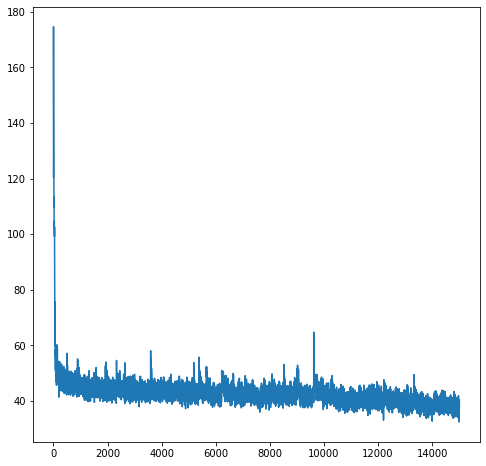

-------------------------------------
6
(94093, 36) (94093, 6)
--- Model ---
| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=36, forecast_length=6, share_thetas=False) at @23316102221776
| --  Stack Generic (#1) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=36, forecast_length=6, share_thetas=False) at @23316647200920
| --  Stack Generic (#2) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=36, forecast_length=6, share_thetas=False) at @23316650554592
| --  Stack Generic (#3) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=36, forecast_length=6, share_thetas=False) at @23316102355824
| --  Stack Generic (#4) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=36, forecast_length=6, share_thetas=False) at @23316102059400
| --  St

grad_step = 007200, loss = 37.513672
grad_step = 007300, loss = 38.071083
grad_step = 007400, loss = 36.957615
grad_step = 007500, loss = 38.569492
grad_step = 007600, loss = 40.143936
grad_step = 007700, loss = 38.745003
grad_step = 007800, loss = 38.704582
grad_step = 007900, loss = 37.734112
grad_step = 008000, loss = 34.908909
grad_step = 008100, loss = 38.411068
grad_step = 008200, loss = 36.987270
grad_step = 008300, loss = 35.390526
grad_step = 008400, loss = 34.095226
grad_step = 008500, loss = 37.795532
grad_step = 008600, loss = 40.053780
grad_step = 008700, loss = 40.988503
grad_step = 008800, loss = 38.229996
grad_step = 008900, loss = 39.697262
grad_step = 009000, loss = 35.967270
grad_step = 009100, loss = 39.504852
grad_step = 009200, loss = 36.526279
grad_step = 009300, loss = 36.364834
grad_step = 009400, loss = 36.537712
grad_step = 009500, loss = 37.619114
grad_step = 009600, loss = 34.247242
grad_step = 009700, loss = 37.442036
grad_step = 009800, loss = 36.048252
g

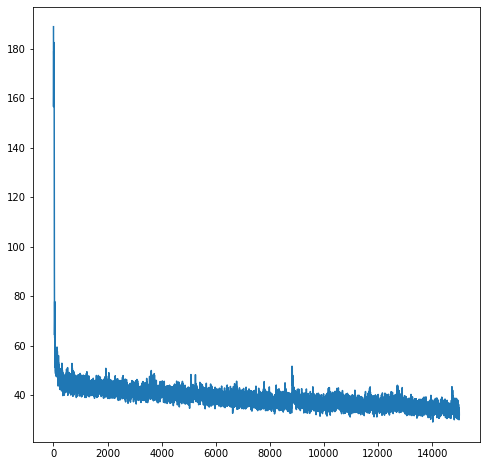

-------------------------------------
7
(94093, 42) (94093, 6)
--- Model ---
| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=42, forecast_length=6, share_thetas=False) at @23316101815544
| --  Stack Generic (#1) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=42, forecast_length=6, share_thetas=False) at @23316651017272
| --  Stack Generic (#2) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=42, forecast_length=6, share_thetas=False) at @23316064378216
| --  Stack Generic (#3) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=42, forecast_length=6, share_thetas=False) at @23316645383248
| --  Stack Generic (#4) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=42, forecast_length=6, share_thetas=False) at @23316651216512
| --  St

grad_step = 007200, loss = 40.124268
grad_step = 007300, loss = 41.907322
grad_step = 007400, loss = 36.428463
grad_step = 007500, loss = 38.404026
grad_step = 007600, loss = 41.624527
grad_step = 007700, loss = 40.354641
grad_step = 007800, loss = 41.434330
grad_step = 007900, loss = 39.681404
grad_step = 008000, loss = 37.565983
grad_step = 008100, loss = 38.452919
grad_step = 008200, loss = 39.623417
grad_step = 008300, loss = 44.278236
grad_step = 008400, loss = 42.567879
grad_step = 008500, loss = 43.894501
grad_step = 008600, loss = 39.532314
grad_step = 008700, loss = 40.811832
grad_step = 008800, loss = 38.242401
grad_step = 008900, loss = 38.438953
grad_step = 009000, loss = 37.107323
grad_step = 009100, loss = 39.906101
grad_step = 009200, loss = 40.532253
grad_step = 009300, loss = 37.348122
grad_step = 009400, loss = 41.462971
grad_step = 009500, loss = 40.503956
grad_step = 009600, loss = 40.854710
grad_step = 009700, loss = 38.531570
grad_step = 009800, loss = 40.506382
g

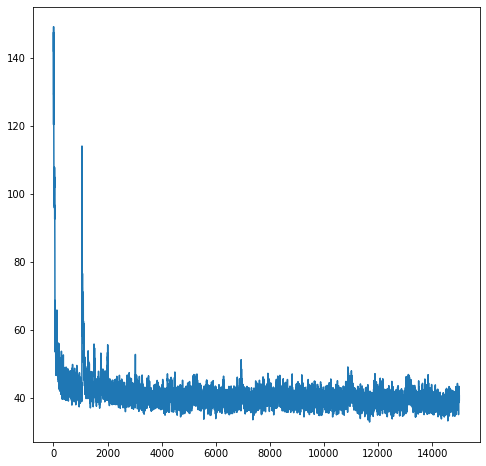

In [2]:
# parameter to set ('yearly', 'quarterly', 'monthly', 'weekly', 'daily', 'hourly') for M4
# ('yearly', 'quarterly', 'monthly') for fred         
data_type = 'yearly'
dataset = 'fred'

if data_type == 'yearly':
    forecast_length = 6
    Lh = 1.5
    max_grad_steps = 15000
elif data_type == 'quarterly':
    forecast_length = 8
    Lh = 1.5
    max_grad_steps = 15000
elif data_type == 'monthly':
    forecast_length = 18
    Lh = 1.5
    max_grad_steps = 15000
elif data_type == 'weekly':
    forecast_length = 13
    Lh = 10
    max_grad_steps = 5000
elif data_type == 'daily':
    forecast_length = 14
    Lh = 10
    max_grad_steps = 5000
else: # data_type == 'hourly'
    forecast_length = 48
    Lh = 10
    max_grad_steps = 5000

batch_size = 1024
    
folder = './{}_checkpoints_{}/'.format(dataset, data_type)

for i in range(2, 8):
    print('-------------------------------------')
    print(i)
    
    device = 'cuda:1' if torch.cuda.is_available() else torch.device('cpu')
    backcast_length = i * forecast_length

    if dataset == 'm4':
        x, y = get_m4_data_training(backcast_length, forecast_length, Lh, data_type)
        
        # scaling data for m4 (does not contain negative elements)
        max_consts = x.max(axis=1)
        x_scaled = x.copy()
        for j in range(x.shape[1]):
            x_scaled[:, j] /= max_consts

        y_scaled = y.copy()
        for j in range(y.shape[1]):
            y_scaled[:, j] /= max_consts
        
    else: # dataset == 'fred'
        x, y = get_fred_data_training(backcast_length, forecast_length, Lh, data_type)
        
        max_consts = np.empty(x.shape[0])
        min_consts = np.empty(x.shape[0])
        nonzero_mask = np.ones(x.shape[0], dtype=bool)
        x_scaled = x.copy()
        for j in range(x_scaled.shape[0]):
            ts_nonzero = np.trim_zeros(x_scaled[j], 'f')
            # all-zeros array - drop from training
            if len(ts_nonzero) == 0:
                nonzero_mask[j] = False
                continue
            max_consts[j] = ts_nonzero.max()
            min_consts[j] = ts_nonzero.min()
            # drop ts from learning if it is constant
            if max_consts[j] == min_consts[j]:
                nonzero_mask[j] = False
                continue
            x_scaled[j, -len(ts_nonzero):] = (ts_nonzero - min_consts[j]) / \
                                                 (max_consts[j] - min_consts[j])
    
        x_scaled = x_scaled[nonzero_mask]
        max_consts = max_consts[nonzero_mask]
        min_consts = min_consts[nonzero_mask]
        y_scaled = y.copy()[nonzero_mask]
        for j in range(y_scaled.shape[0]):
            ts_y_nonzero = np.trim_zeros(y_scaled[j], 'b')
            y_scaled[j, :len(ts_y_nonzero)] = (ts_y_nonzero - min_consts[j]) / \
                                                 (max_consts[j] - min_consts[j])
    
    data_gen = batcher(x_scaled, y_scaled, batch_size=batch_size, infinite=True)
    
    checkpoint_name = '{}{}_share_{}H_G_2_smape.th'.\
                            format(folder, data_type[:-2], i)
    
    print('--- Model ---')
    n_stacks = 30
    net = NBeatsNet(device=device,
                    stack_types=[NBeatsNet.GENERIC_BLOCK] * n_stacks,
                    forecast_length=forecast_length,
                    thetas_dims=[4] * n_stacks,
                    nb_blocks_per_stack=1,
                    backcast_length=backcast_length,
                    hidden_layer_units=512,
                    share_weights_in_stack=True
                    )

    optimiser = optim.Adam(net.parameters())

    def plot_model(x, target, grad_step):
        plot(net, x, target, backcast_length, forecast_length, grad_step)

    losses = fit_smape(net, optimiser, data_gen, plot_model, device, \
                              max_grad_steps, checkpoint_name)

-------------------------------------
2
(94093, 12) (94093, 6)
--- Model ---
| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=12, forecast_length=6, share_thetas=False) at @22955204871952
| --  Stack Generic (#1) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=12, forecast_length=6, share_thetas=False) at @22955202563432
| --  Stack Generic (#2) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=12, forecast_length=6, share_thetas=False) at @22955202561808
| --  Stack Generic (#3) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=12, forecast_length=6, share_thetas=False) at @22955202562592
| --  Stack Generic (#4) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=12, forecast_length=6, share_thetas=False) at @22955202562256
| --  St

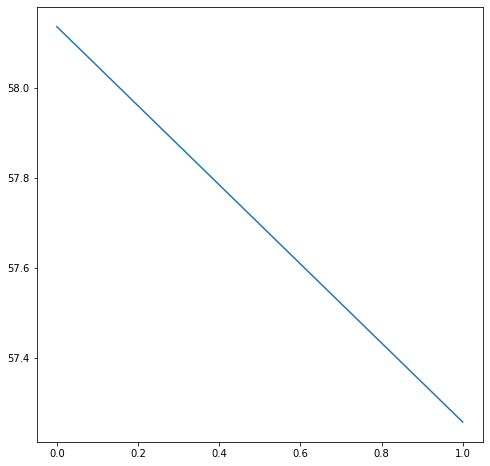

-------------------------------------
3
(94093, 18) (94093, 6)
--- Model ---
| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=18, forecast_length=6, share_thetas=False) at @22954817164624
| --  Stack Generic (#1) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=18, forecast_length=6, share_thetas=False) at @22954800519208
| --  Stack Generic (#2) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=18, forecast_length=6, share_thetas=False) at @22954816942936
| --  Stack Generic (#3) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=18, forecast_length=6, share_thetas=False) at @22954817032768
| --  Stack Generic (#4) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=18, forecast_length=6, share_thetas=False) at @22954817034224
| --  St

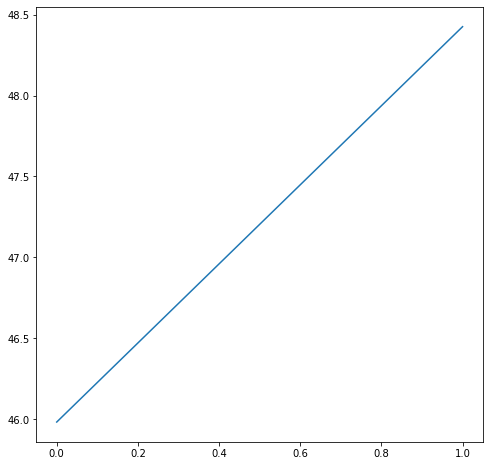

-------------------------------------
4
(94093, 24) (94093, 6)
--- Model ---
| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=24, forecast_length=6, share_thetas=False) at @22954821991952
| --  Stack Generic (#1) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=24, forecast_length=6, share_thetas=False) at @22954817346416
| --  Stack Generic (#2) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=24, forecast_length=6, share_thetas=False) at @22954821773800
| --  Stack Generic (#3) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=24, forecast_length=6, share_thetas=False) at @22954822216840
| --  Stack Generic (#4) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=24, forecast_length=6, share_thetas=False) at @22954822044808
| --  St

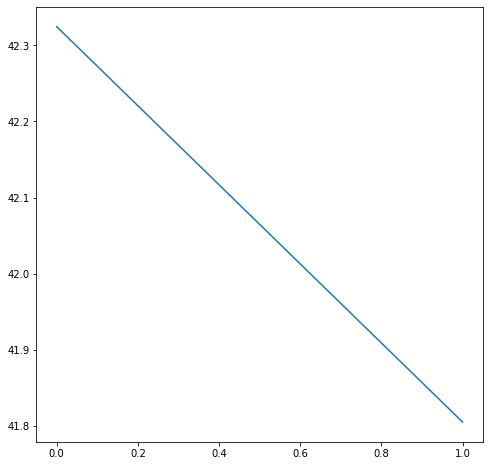

-------------------------------------
5
(94093, 30) (94093, 6)
--- Model ---
| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=30, forecast_length=6, share_thetas=False) at @22954821360384
| --  Stack Generic (#1) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=30, forecast_length=6, share_thetas=False) at @22954817402808
| --  Stack Generic (#2) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=30, forecast_length=6, share_thetas=False) at @22954814594072
| --  Stack Generic (#3) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=30, forecast_length=6, share_thetas=False) at @22954814302752
| --  Stack Generic (#4) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=30, forecast_length=6, share_thetas=False) at @22954814302640
| --  St

grad_step = 009000, loss = 43.256874
grad_step = 009100, loss = 44.953815
grad_step = 009200, loss = 43.901020
grad_step = 009300, loss = 41.786160
grad_step = 009400, loss = 56.121750
grad_step = 009500, loss = 41.411587
grad_step = 009600, loss = 44.226200
grad_step = 009700, loss = 40.835175
grad_step = 009800, loss = 44.233967
grad_step = 009900, loss = 40.924129
grad_step = 010000, loss = 43.144180
grad_step = 010100, loss = 42.175228
grad_step = 010200, loss = 47.521721
grad_step = 010300, loss = 43.267120
grad_step = 010400, loss = 41.450611
grad_step = 010500, loss = 43.358143
grad_step = 010600, loss = 45.120876
grad_step = 010700, loss = 45.883377
grad_step = 010800, loss = 65.378090
grad_step = 010900, loss = 46.624287
grad_step = 011000, loss = 48.280682
grad_step = 011100, loss = 42.783810
grad_step = 011200, loss = 48.706432
grad_step = 011300, loss = 46.038177
grad_step = 011400, loss = 46.202583
grad_step = 011500, loss = 44.690613
grad_step = 011600, loss = 42.848537
g

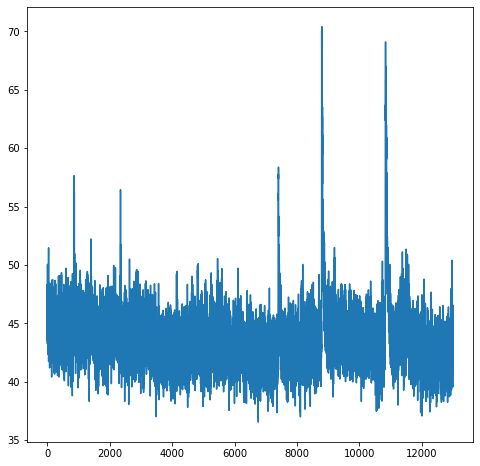

-------------------------------------
6
(94093, 36) (94093, 6)
--- Model ---
| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=36, forecast_length=6, share_thetas=False) at @22954813838112
| --  Stack Generic (#1) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=36, forecast_length=6, share_thetas=False) at @22954821586224
| --  Stack Generic (#2) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=36, forecast_length=6, share_thetas=False) at @22954822284120
| --  Stack Generic (#3) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=36, forecast_length=6, share_thetas=False) at @22954820164072
| --  Stack Generic (#4) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=36, forecast_length=6, share_thetas=False) at @22954822437968
| --  St

grad_step = 007200, loss = 39.493580
grad_step = 007300, loss = 38.710072
grad_step = 007400, loss = 40.663685
grad_step = 007500, loss = 41.303562
grad_step = 007600, loss = 39.910336
grad_step = 007700, loss = 36.704491
grad_step = 007800, loss = 43.724663
grad_step = 007900, loss = 42.735573
grad_step = 008000, loss = 41.005741
grad_step = 008100, loss = 43.187805
grad_step = 008200, loss = 39.546585
grad_step = 008300, loss = 41.429581
grad_step = 008400, loss = 42.283363
grad_step = 008500, loss = 41.663349
grad_step = 008600, loss = 44.625710
grad_step = 008700, loss = 41.453926
grad_step = 008800, loss = 40.048756
grad_step = 008900, loss = 42.084850
grad_step = 009000, loss = 41.178802
grad_step = 009100, loss = 38.341614
grad_step = 009200, loss = 44.003532
grad_step = 009300, loss = 44.661636
grad_step = 009400, loss = 40.947796
grad_step = 009500, loss = 41.466061
grad_step = 009600, loss = 41.553192
grad_step = 009700, loss = 40.981628
grad_step = 009800, loss = 39.093010
g

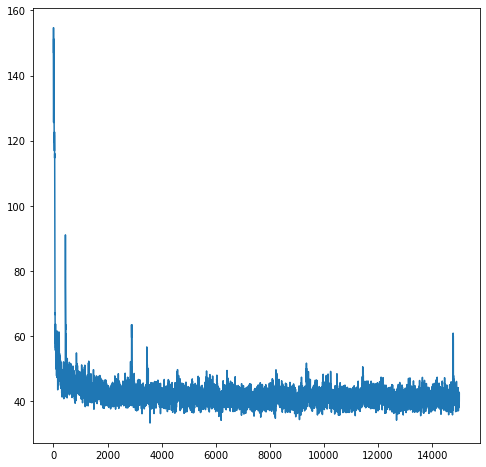

-------------------------------------
7
(94093, 42) (94093, 6)
--- Model ---
| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=42, forecast_length=6, share_thetas=False) at @22954800521168
| --  Stack Generic (#1) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=42, forecast_length=6, share_thetas=False) at @22954820272368
| --  Stack Generic (#2) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=42, forecast_length=6, share_thetas=False) at @22954816633600
| --  Stack Generic (#3) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=42, forecast_length=6, share_thetas=False) at @22954816131592
| --  Stack Generic (#4) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=42, forecast_length=6, share_thetas=False) at @22954816132824
| --  St

grad_step = 007200, loss = 37.397362
grad_step = 007300, loss = 37.580170
grad_step = 007400, loss = 37.781395
grad_step = 007500, loss = 35.865410
grad_step = 007600, loss = 44.618877
grad_step = 007700, loss = 35.515430
grad_step = 007800, loss = 38.636002
grad_step = 007900, loss = 37.746197
grad_step = 008000, loss = 38.860256
grad_step = 008100, loss = 37.588787
grad_step = 008200, loss = 36.802856
grad_step = 008300, loss = 38.480175
grad_step = 008400, loss = 36.269936
grad_step = 008500, loss = 38.679523
grad_step = 008600, loss = 37.344418
grad_step = 008700, loss = 36.072495
grad_step = 008800, loss = 36.015026
grad_step = 008900, loss = 38.712238
grad_step = 009000, loss = 37.207951
grad_step = 009100, loss = 35.053761
grad_step = 009200, loss = 34.584736
grad_step = 009300, loss = 35.492477
grad_step = 009400, loss = 37.392185
grad_step = 009500, loss = 34.812134
grad_step = 009600, loss = 35.274330
grad_step = 009700, loss = 36.554058
grad_step = 009800, loss = 33.958405
g

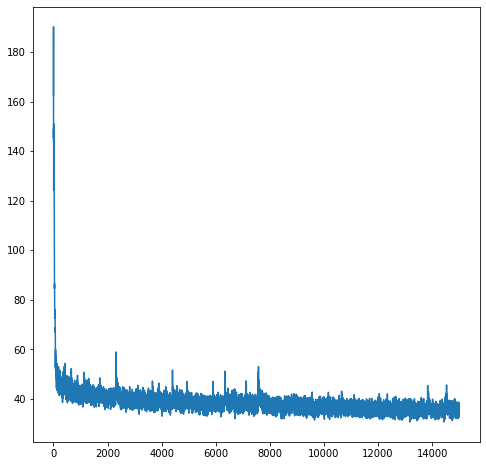

In [2]:
# parameter to set ('yearly', 'quarterly', 'monthly', 'weekly', 'daily', 'hourly') for M4
# ('yearly', 'quarterly', 'monthly') for fred         
data_type = 'yearly'
dataset = 'fred'

if data_type == 'yearly':
    forecast_length = 6
    Lh = 1.5
    max_grad_steps = 15000
elif data_type == 'quarterly':
    forecast_length = 8
    Lh = 1.5
    max_grad_steps = 15000
elif data_type == 'monthly':
    forecast_length = 18
    Lh = 1.5
    max_grad_steps = 15000
elif data_type == 'weekly':
    forecast_length = 13
    Lh = 10
    max_grad_steps = 5000
elif data_type == 'daily':
    forecast_length = 14
    Lh = 10
    max_grad_steps = 5000
else: # data_type == 'hourly'
    forecast_length = 48
    Lh = 10
    max_grad_steps = 5000

batch_size = 1024
    
folder = './{}_checkpoints_{}/'.format(dataset, data_type)

for i in range(2, 8):
    print('-------------------------------------')
    print(i)
    
    device = 'cuda:1' if torch.cuda.is_available() else torch.device('cpu')
    backcast_length = i * forecast_length

    if dataset == 'm4':
        x, y = get_m4_data_training(backcast_length, forecast_length, Lh, data_type)
        
        # scaling data for m4 (does not contain negative elements)
        max_consts = x.max(axis=1)
        x_scaled = x.copy()
        for j in range(x.shape[1]):
            x_scaled[:, j] /= max_consts

        y_scaled = y.copy()
        for j in range(y.shape[1]):
            y_scaled[:, j] /= max_consts
        
    else: # dataset == 'fred'
        x, y = get_fred_data_training(backcast_length, forecast_length, Lh, data_type)
        
        max_consts = np.empty(x.shape[0])
        min_consts = np.empty(x.shape[0])
        nonzero_mask = np.ones(x.shape[0], dtype=bool)
        x_scaled = x.copy()
        for j in range(x_scaled.shape[0]):
            ts_nonzero = np.trim_zeros(x_scaled[j], 'f')
            # all-zeros array - drop from training
            if len(ts_nonzero) == 0:
                nonzero_mask[j] = False
                continue
            max_consts[j] = ts_nonzero.max()
            min_consts[j] = ts_nonzero.min()
            # drop ts from learning if it is constant
            if max_consts[j] == min_consts[j]:
                nonzero_mask[j] = False
                continue
            x_scaled[j, -len(ts_nonzero):] = (ts_nonzero - min_consts[j]) / \
                                                 (max_consts[j] - min_consts[j])
    
        x_scaled = x_scaled[nonzero_mask]
        max_consts = max_consts[nonzero_mask]
        min_consts = min_consts[nonzero_mask]
        y_scaled = y.copy()[nonzero_mask]
        for j in range(y_scaled.shape[0]):
            ts_y_nonzero = np.trim_zeros(y_scaled[j], 'b')
            y_scaled[j, :len(ts_y_nonzero)] = (ts_y_nonzero - min_consts[j]) / \
                                                 (max_consts[j] - min_consts[j])
    
    data_gen = batcher(x_scaled, y_scaled, batch_size=batch_size, infinite=True)
    
    checkpoint_name = '{}{}_share_{}H_G_3_smape.th'.\
                            format(folder, data_type[:-2], i)
    
    print('--- Model ---')
    n_stacks = 30
    net = NBeatsNet(device=device,
                    stack_types=[NBeatsNet.GENERIC_BLOCK] * n_stacks,
                    forecast_length=forecast_length,
                    thetas_dims=[4] * n_stacks,
                    nb_blocks_per_stack=1,
                    backcast_length=backcast_length,
                    hidden_layer_units=512,
                    share_weights_in_stack=True
                    )

    optimiser = optim.Adam(net.parameters())

    def plot_model(x, target, grad_step):
        plot(net, x, target, backcast_length, forecast_length, grad_step)

    losses = fit_smape(net, optimiser, data_gen, plot_model, device, \
                              max_grad_steps, checkpoint_name)